In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

%matplotlib inline
#scp bajarey2@192.168.0.53:BajaRey/lib/python3.13/site-packages/truck/demonstrations-evan.npz .
print("Libraries loaded successfully!")

Libraries loaded successfully!


## Step 1: Load Demonstration Data

Load the expert demonstration data collected from the vehicle.

In [20]:
def load_demonstration_data(filename='demonstrations-evan.npz'):
    """Load PID demonstration data from single file."""
    try:
        data = np.load(filename)
        states = data['states']
        actions = data['actions']
        rewards = data['rewards']
        
        print(f"Loaded data from {filename}")
        print(f"Total transitions: {len(states)}")
        print(f"State shape: {states.shape}")
        print(f"Action range: [{actions.min():.0f}, {actions.max():.0f}] us")
        print(f"Reward range: [{rewards.min():.2f}, {rewards.max():.2f}]")
        print(f"Mean reward: {rewards.mean():.2f}")
        
        return states, actions, rewards
    
    except FileNotFoundError:
        print(f"File not found: {filename}")
        print("Run BajaRey.py in mode 2 first to collect data.")
        return None, None, None

# Load the data
states, actions, rewards = load_demonstration_data('demonstrations-evan.npz')

Loaded data from demonstrations-evan.npz
Total transitions: 1501
State shape: (1501, 2)
Action range: [1000, 2000] us
Reward range: [-12.43, 142.16]
Mean reward: 3.01


## Step 2: Visualize Demonstration Data

Examine the distribution of states, actions, and rewards.

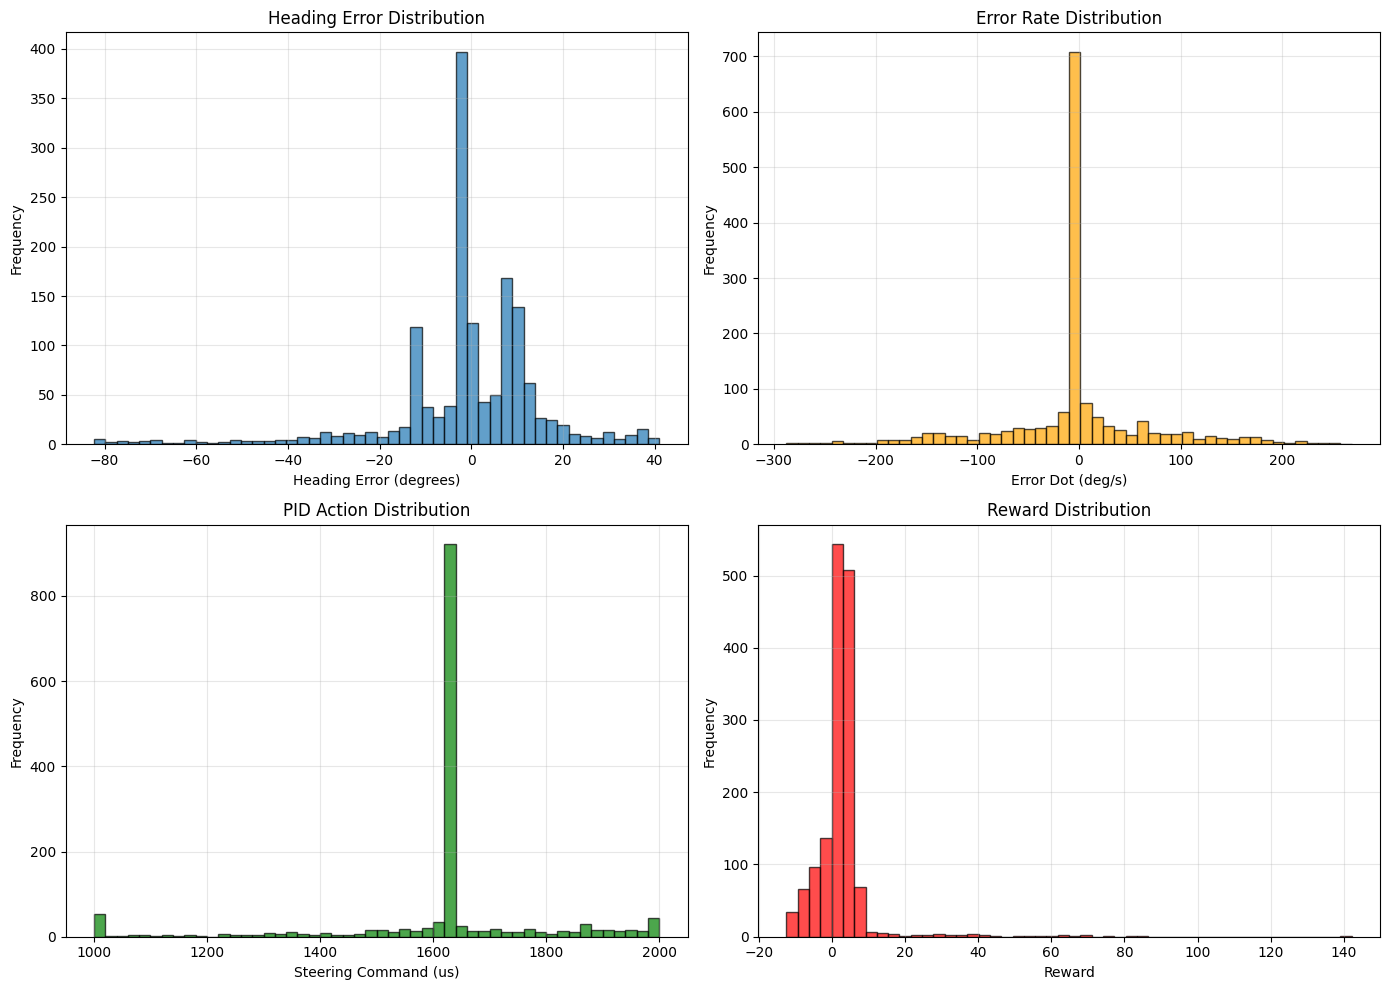

In [21]:
if states is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Heading Error distribution
    axes[0, 0].hist(states[:, 0], bins=50, alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Heading Error (degrees)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Heading Error Distribution')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Error_dot distribution
    axes[0, 1].hist(states[:, 1], bins=50, alpha=0.7, edgecolor='black', color='orange')
    axes[0, 1].set_xlabel('Error Dot (deg/s)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Error Rate Distribution')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Action distribution
    axes[1, 0].hist(actions, bins=50, alpha=0.7, edgecolor='black', color='green')
    axes[1, 0].set_xlabel('Steering Command (us)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('PID Action Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Reward distribution
    axes[1, 1].hist(rewards, bins=50, alpha=0.7, edgecolor='black', color='red')
    axes[1, 1].set_xlabel('Reward')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Reward Distribution')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Step 3: Define Linear Regression Model

Simple linear model: steering_us = bias + w1*heading_error + w2*error_dot

In [ ]:
class RegressionModel:
    """Wrapper around scikit-learn's LinearRegression for steering prediction.
    
    Model: steering_us = w0 + w1*heading_error + w2*error_dot
    """
    def __init__(self, state_dim=2):
        self.state_dim = state_dim
        self.model = LinearRegression()
        self.predictions = None
        
    def fit(self, states, actions):
        """Fit linear regression using scikit-learn.
        
        Args:
            states: array of states [N, state_dim] (heading_error, error_dot)
            actions: array of steering commands [N] (1000-2000 us)
        """
        # Fit the model
        self.model.fit(states, actions)
        
        # Get predictions
        self.predictions = self.model.predict(states)
        
        # Clip predictions to valid steering range
        self.predictions = np.clip(self.predictions, 1000, 2000)
        
        # Compute metrics
        mse = mean_squared_error(actions, self.predictions)
        mae = mean_absolute_error(actions, self.predictions)
        r2 = r2_score(actions, self.predictions)
        
        print(f"Linear Regression Training Complete:")
        print(f"  Intercept (bias): {self.model.intercept_:.2f}")
        print(f"  Coefficients: {self.model.coef_}")
        print(f"  MSE: {mse:.2f} us^2")
        print(f"  MAE: {mae:.2f} us")
        print(f"  R² score: {r2:.4f}")
        print(f"\nModel equation:")
        print(f"  steering = {self.model.intercept_:.2f} + {self.model.coef_[0]:.4f}*heading_error + {self.model.coef_[1]:.4f}*error_dot")
        
        return self.predictions
    
    def predict(self, states):
        """Predict steering commands for given states."""
        if states.ndim == 1:
            states = states.reshape(1, -1)
        
        predictions = self.model.predict(states)
        
        # Clip to valid steering range
        predictions = np.clip(predictions, 1000, 2000)
        
        if len(predictions) == 1:
            return predictions[0]
        return predictions
    
    def save(self, filename='linear_model.pkl'):
        """Save model to file using joblib."""
        joblib.dump(self.model, filename)
        print(f"Model saved to {filename}")

if states is not None:
    # Create and fit linear regression model
    model = RegressionModel(state_dim=2)
    print("Scikit-learn linear regression model created!")
    print(f"State dimension: {model.state_dim}")

Scikit-learn linear regression model created!
State dimension: 2


## Step 4: Train Linear Regression Model

Fit the model using scikit-learn's LinearRegression.

In [23]:
if states is not None:
    print("Training linear regression model using scikit-learn...")
    print("Using LinearRegression with L2 regularization for numerical stability\n")
    
    # Fit the model
    predictions = model.fit(states, actions)

Training linear regression model using scikit-learn...
Using LinearRegression with L2 regularization for numerical stability

Linear Regression Training Complete:
  Intercept (bias): 1620.54
  Coefficients: [ 4.86680404 -0.04482281]
  MSE: 27598.00 us^2
  MAE: 99.46 us
  R² score: 0.1868

Model equation:
  steering = 1620.54 + 4.8668*heading_error + -0.0448*error_dot


## Step 5: Visualize Model Fit

Saved plots to 'linear_regression_results.png'


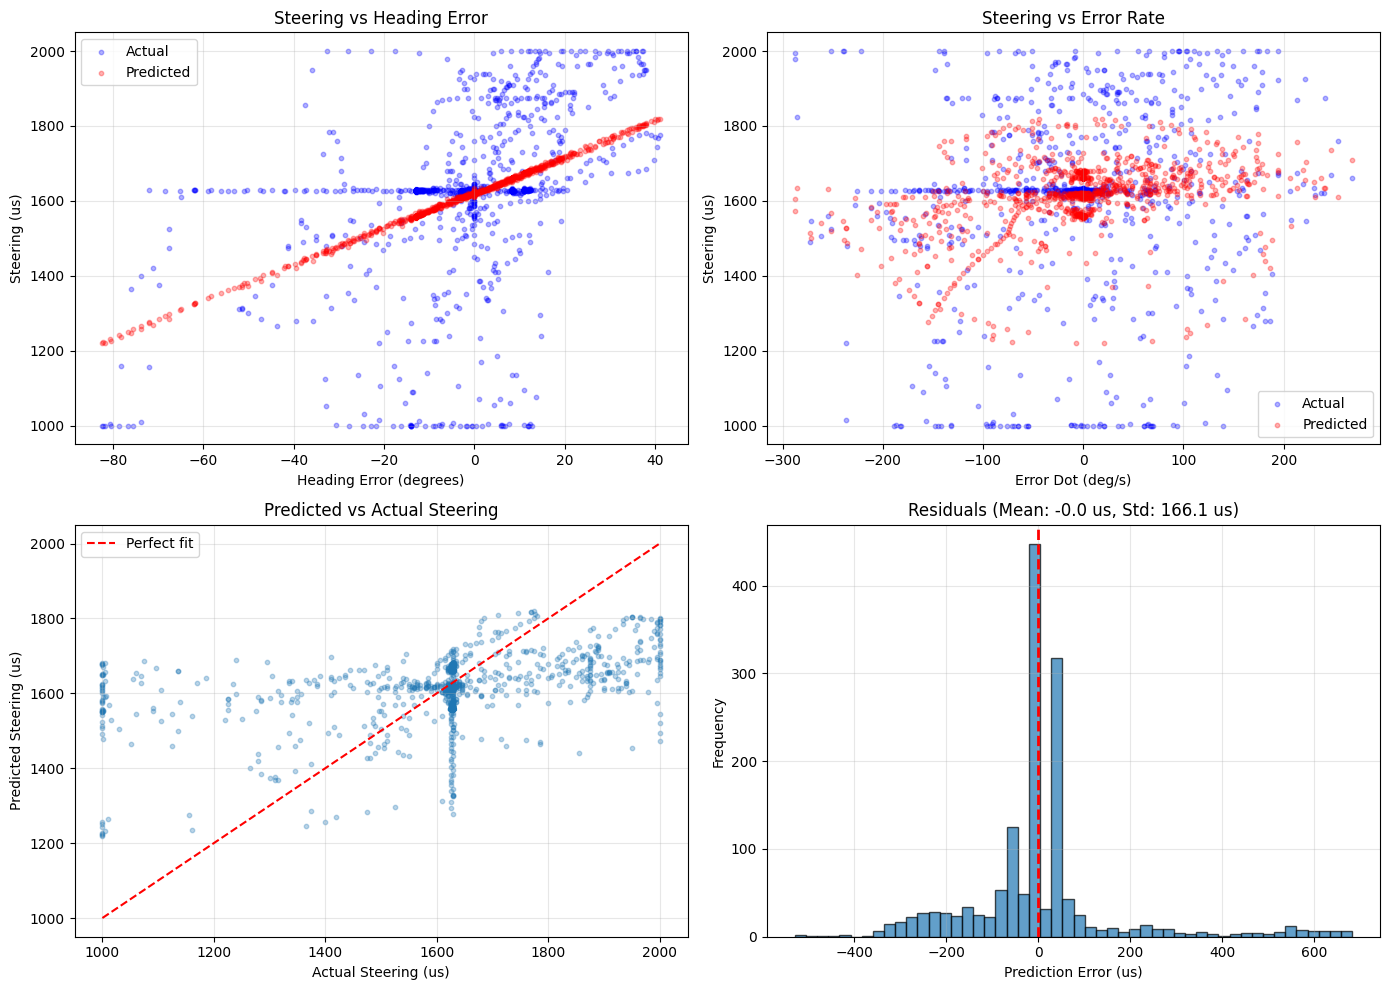


Model Statistics:
  R² score: 0.1868
  Mean Absolute Error: 99.46 us
  Root Mean Squared Error: 166.13 us


In [24]:
if states is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Steering vs Heading Error
    ax = axes[0, 0]
    ax.scatter(states[:, 0], actions, alpha=0.3, s=10, label='Actual', c='blue')
    ax.scatter(states[:, 0], predictions, alpha=0.3, s=10, label='Predicted', c='red')
    ax.set_xlabel('Heading Error (degrees)')
    ax.set_ylabel('Steering (us)')
    ax.set_title('Steering vs Heading Error')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Steering vs Error_dot
    ax = axes[0, 1]
    ax.scatter(states[:, 1], actions, alpha=0.3, s=10, label='Actual', c='blue')
    ax.scatter(states[:, 1], predictions, alpha=0.3, s=10, label='Predicted', c='red')
    ax.set_xlabel('Error Dot (deg/s)')
    ax.set_ylabel('Steering (us)')
    ax.set_title('Steering vs Error Rate')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Predicted vs Actual
    ax = axes[1, 0]
    ax.scatter(actions, predictions, alpha=0.3, s=10)
    ax.plot([1000, 2000], [1000, 2000], 'r--', label='Perfect fit')
    ax.set_xlabel('Actual Steering (us)')
    ax.set_ylabel('Predicted Steering (us)')
    ax.set_title('Predicted vs Actual Steering')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Residuals
    ax = axes[1, 1]
    residuals = predictions - actions
    ax.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='r', linestyle='--', linewidth=2)
    ax.set_xlabel('Prediction Error (us)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Residuals (Mean: {np.mean(residuals):.1f} us, Std: {np.std(residuals):.1f} us)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('linear_regression_results.png', dpi=150)
    print("Saved plots to 'linear_regression_results.png'")
    plt.show()
    
    # Print statistics
    print(f"\nModel Statistics:")
    print(f"  R² score: {1 - np.var(residuals) / np.var(actions):.4f}")
    print(f"  Mean Absolute Error: {np.mean(np.abs(residuals)):.2f} us")
    print(f"  Root Mean Squared Error: {np.sqrt(np.mean(residuals**2)):.2f} us")

## Step 6: Save Trained Model

In [25]:
if states is not None:
    # Save trained model
    model.save('linear_model.pkl')
    print("\nDeployment instructions:")
    print("1. Copy 'linear_model.pkl' to the Raspberry Pi")
    print("2. In BajaRey.py, set DRIVE_MODE = 4 to use linear regression inference")
    print("3. Run BajaRey.py and observe the model's performance!")

Model saved to linear_model.pkl

Deployment instructions:
1. Copy 'linear_model.pkl' to the Raspberry Pi
2. In BajaRey.py, set DRIVE_MODE = 4 to use linear regression inference
3. Run BajaRey.py and observe the model's performance!


In [ ]:
#scp linear_model.pkl bajarey2@192.168.0.53:BajaRey/lib/python3.13/site-packages/truck/